In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cmath
import math

## 5. Hydrogen Atom: Variational Method

The variational method requires taking a system and making an educated guess for that system. Let's think about the hydrogen atom. It has an electron and a proton. Experimentally, we know that the atom has some maximum radius, which we will call $a_0$. The electron then must have its wavefunction go to zero outside of the radius of the atom. Otherwise, we might find an electron very far away from the atom. Of course, strictly speaking experimentally, we would like to not completely rule out this possibility, so let's say it's very small or close to zero outside of $a_0$. What about as the electron approaches the proton, i.e. $r \rightarrow 0$? The probability has to add up to 1, so it cannot go to infinity. From Rutherford's gold foil experiment, we know that the atom is comprised of a small, dense nucleus, with electrons some distance from the nucleus. So, the electrons are unlikely to be at $r=0$. Thus, we assume that the probability goes to zero as $r \rightarrow 0$.

So we have a function that starts and ends at zero. It cannot be zero everywhere, otherwise the electron is nowhere. So, there must be at least one peak. 

Since we are talking about the probability here, we are looking for a function $\psi(r, \theta, \phi)$ such that:

$$
f(r, \theta, \phi) = \left|\psi(r, \theta, \phi)\right|^2 r^2
$$

has the aforementioned properties.

One guess is:

$$
u(r) = r \theta_0 e^{-(r-\theta_1)/\theta_2}
$$

### Analytical Solution

Our guess here is of course known to be the right form of the solution, as we know analytically that, for the ground state (in atomic units):

$$
\begin{align}
R(r) &= 2 e^{-r} \\
u(r) &= 2 r e^{-r}
\end{align}
$$

Here we will plot the ground state wavefunction probability in ($r, \phi$) as a 3D surface plot. Since we want to show probability, we can only show 2 out of the 3 possible spherical coordinates $(r, \theta, \phi)$. 

In [1]:
def psi_100(probability=True):
    """Wavefunction for Hydrogen atom in ground state.
    
    Args:
        probability: (bool) If true, return the wavefunction probability

    """
    h_bar = 1 # reduced Planck constant
    m = 1 # mass of an electron
    alpha = -h_bar**2/(2*m)
    E = -1
    q = -1
    k = q**2
    a = 1
    r_data = np.linspace(0, 20, 50)
    phi_data = np.linspace(0, 2*np.pi, 50)
    r_data, phi_data = np.meshgrid(r_data, phi_data)
    if probability:
        psi_data = 1/(np.pi*a**3)*np.exp(-2*r_data/a)*r_data**2
    else:
        psi_data = 1/np.sqrt(np.pi*a**3)*np.exp(-r_data/a)
    return r_data, phi_data, psi_data

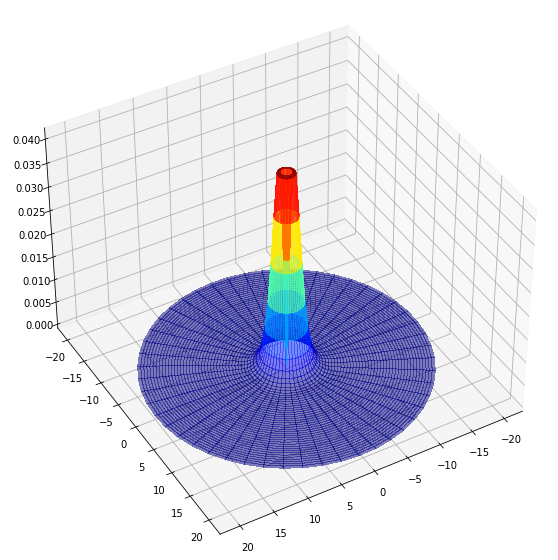

In [4]:
parameters = {
    'axes.labelsize': 14,
    'axes.titlesize': 14
}
plt.rcParams.update(parameters)

fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.view_init(40, 60)

r_data, phi_data, psi_data = psi_100()
X, Y = r_data*np.cos(phi_data), r_data*np.sin(phi_data)
Z = psi_data
plot = ax.plot_surface(
    X, Y, Z, rstride=1, cstride=1, cmap=plt.get_cmap('jet'),
    linewidth=0, antialiased=False, alpha=0.5)

plt.show()

### Numerical Solution

#### Gradient Descent

We want to use gradient descent to compute the optimized coefficients for our guess of the wavefunction:

$$
u(r) = r \theta_0 e^{-(r-\theta_1)/\theta_2}
$$

Here we have a cost function:

$$
J(\theta_0, \theta_1, \theta_2)
$$

and we for each iteration of gradient descent we update $\theta_l$:

$$
\begin{align}
\theta_0^{(k+1)} &= \theta_0^{(k)} - \alpha \dfrac{\partial J}{\partial \theta_0} \\
\theta_1^{(k+1)} &= \theta_1^{(k)} - \alpha \dfrac{\partial J}{\partial \theta_1} \\
\theta_2^{(k+1)} &= \theta_2^{(k)} - \alpha \dfrac{\partial J}{\partial \theta_2} \\
\end{align}
$$

One of the nice things about the cost function is you can design it yourself. It needs to include our variables $(\theta_0, \theta_1, \theta_2)$, and also some measure of how our function $u(r)$ is performing. So, we define our cost function as follows:

$$
J(\theta_0, \theta_1, \theta_2) = \dfrac{1}{N}\sum_{i=0}^N \left[\dfrac{\partial^2 u(r_i, \theta_0, \theta_1, \theta_2)}{\partial r^2} - 2\left(\dfrac{l(l+1)}{2r_i^2} - E - \dfrac{1}{r_i}\right)u(r_i, \theta_0, \theta_1, \theta_2)\right]^2
$$

#### Results

In [6]:
import gradient_descent_variational_method as gdvm

In [7]:
r_data = np.arange(0.01, 10, 0.05)
num_data_points = len(r_data)
print(f"Number of data points in r: {num_data_points}")

Number of data points in r: 200


In [9]:
hydrogen = gdvm.Hydrogen()
u_actual = gdvm.get_R_vector(r_data, [2, 0, 1])
alpha = 10**(-6)
max_cost = 0.05

##### Initial Coefficients Close to Analytical Solution

In [10]:
coefficients = [2, 0.05, 1]
u_initial = gdvm.get_R_vector(r_data, coefficients)
u_pred = u_initial

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(35,12))
# fig.suptitle("Finite Difference Method for a Particle in a 1D Well, Stationary State, n = 1")

max_iterations = 6000
ind = 1
for ax in axes.flat:
    
    u_pred = u_initial
    coefficients, cost = gdvm.gradient_descent(coefficients, alpha, max_cost, max_iterations, gdvm.cost_function,
                                           gdvm.cost_function_deriv, r_data, hydrogen)
    u_pred = gdvm.get_R_vector(r_data, coefficients)
    
    ax.plot(r_data, (u_actual)**2, label="True Value", color="#1cc9a2")
    ax.plot(r_data, (u_initial)**2, label="Initial Prediction", color="#636EFA")
    ax.plot(r_data, (u_pred)**2, label="Variational Method", color="#FFA15A")
    ax.legend(loc="upper right")

    ax.set_xlabel("r")
    ax.set_ylabel(r"Probability $ \propto r^2 R(r)$")
    ax.set_title(f"{max_iterations*ind} Iterations")
    ax.text(0.95, 0.8, f'cost = {np.round(cost, 4)}',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color="#1B1464", fontsize=18)
    ax.text(0.95, 0.75, r"$ \alpha = 10^{-6}$",
    verticalalignment='bottom', horizontalalignment='right',
    transform=ax.transAxes,
    color="#1B1464", fontsize=18)
    ind = ind + 1

# plt.show()
plt.savefig(f'variational_method_hydrogen_coefficients_close.png')

##### Initial Coefficients Far From Analytical Solution

In [ ]:
coefficients = [-6, -0.5, 2]
u_initial = gdvm.get_R_vector(r_data, coefficients)
u_pred = u_initial

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(35,12))
# fig.suptitle("Finite Difference Method for a Particle in a 1D Well, Stationary State, n = 1")

max_iterations = 6000
ind = 1
for ax in axes.flat:
    
    u_pred = u_initial
    coefficients, cost = gdvm.gradient_descent(coefficients, alpha, max_cost, max_iterations, gdvm.cost_function,
                                           gdvm.cost_function_deriv, r_data, hydrogen)
    u_pred = gdvm.get_R_vector(r_data, coefficients)
    
    ax.plot(r_data, (u_actual)**2, label="True Value", color="#1cc9a2")
    ax.plot(r_data, (u_initial)**2, label="Initial Prediction", color="#636EFA")
    ax.plot(r_data, (u_pred)**2, label="Variational Method", color="#FFA15A")
    ax.legend(loc="upper right")

    ax.set_xlabel("r")
    ax.set_ylabel(r"Probability $ \propto r^2 R(r)$")
    ax.set_title(f"{max_iterations*ind} Iterations")
    ax.text(0.95, 0.8, f'cost = {np.round(cost, 4)}',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color="#1B1464", fontsize=18)
    ax.text(0.95, 0.75, r"$ \alpha = 10^{-6}$",
    verticalalignment='bottom', horizontalalignment='right',
    transform=ax.transAxes,
    color="#1B1464", fontsize=18)
    ind = ind + 1

# plt.show()
plt.savefig(f'variational_method_hydrogen_coefficients_far.png')